In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,Wedge
from matplotlib.collections import PatchCollection
import numpy as np
import time
from hera_cal import redcal
import cPickle as cp
import h5py
import linsolve
from copy import deepcopy
from tqdm import tqdm

## Sample Covariance matrix

The sample covariance matrix for a $p \times 1$ random vector given $n$ independent observations is given by:

$$Q = \frac{1}{n-1} \Sigma (x_i - \bar{x})(x_i - \bar{x})^T $$

**Properties**:
1. For a gaussian random distribution, the variance is $2\sigma^2$ if the random numbers were drawn with scale$=\sigma$.

2. The sample covariance matrix will *not* have zero off-diagonal terms even though the terms have been drawn independently are not covariant.

3. The off-diagonal terms seem to be proportional to the variance of the variables.

In [ ]:
def noise(loc=0,scale=1,size=1):
    return np.random.normal(loc=loc,scale=scale,size=size) + 1j*np.random.normal(loc=loc,scale=scale,size=size)

In [ ]:
data = np.vstack((noise(scale=1,size=1000),noise(scale=4,size=1000)))
data = np.vstack((data,noise(scale=8,size=1000)))
cov = np.cov(data)

plt.figure(figsize=(8,4))
plt.imshow(np.abs(cov))
plt.colorbar()

# Covariance matrix for Ax=b

For the system of equations represented by $Ax=b$, the covariance matrix is given by the neat formula:

$$Q = (A^TN^{-1}A)^{-1}$$

When the errors are independent (as in our case), the noise covariance matrix drops out and we get:

$$Q = \sigma^2(A^TA)^{-1}$$

In the limit of a large number of solutions for the estimate $\hat{x}$, the sample covariance matrix should equal the above matrix.

$$\Sigma (x_i-\bar{x})(x_i-\bar{x})^T \rightarrow \sigma^2 (A^TA)^{-1}$$

# Logarithmic solution for products

When you have a system of equations involving purely the products of variables, you can solve them by linearlizing with logarithms.

$$xy = 3  \rightarrow \log{x} + \log{y} = \log{3} $$

This becomes more interesting when the variables are complex numbers. The logarithm of a complex number separates the amplitude and phase into the real and imaginary parts when you linearize.

$$x = a + ib = |x|e^{i\phi} = e^{\eta} e^{i\phi} = e^{\eta+i\phi}$$
$$\log{e^{\eta + i\phi}} = \eta + i\phi = \log{|x|} + i\angle{x}$$

So when you are linearizing a system of complex equations, you are naturally solving **two independent systems** of equations- one for the **real or amplitude part** and the other for the **imaginary or phase part** of the variable.

# Example

$$xy = 4i $$
$$xz^* = 6 $$
$$y^*z = 12$$

True solution:

$$x = 1+1j$$
$$y = 2+2j$$
$$z = 3+3j$$

In [ ]:
data = {}
data['x*y'] = 4j
data['x*z_'] = 6
data['y_*z'] = 12

In [ ]:
Ar = [[1, 1, 0], [1, 0, 1], [0, 1, 1]]
Ai = [[1, 1, 0], [1, 0, -1], [0, -1, 1]]
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(np.linalg.inv(np.dot(np.transpose(Ar),Ar)))
plt.colorbar(shrink=0.75)
plt.subplot(122)
plt.imshow(np.linalg.inv(np.dot(np.transpose(Ai),Ai)))
plt.colorbar(shrink=0.75)

In [ ]:
# Actual solution
lps = linsolve.LogProductSolver(data)
sol = lps.solve()
for k,v in sol.items():
    print k, np.log(v)

In [ ]:
X = np.zeros([1,3])
n = np.zeros([1,3])
Nsim = 2**10
for i in range(Nsim):
    noise_sim = noise(size=3)
    data_sim = {}
    for i,k in enumerate(['x','y','z']):
        data_sim[k] = 100*noise_sim[i] 
    lps = linsolve.LogProductSolver(data_sim)
    sol = lps.solve()
    n = np.vstack((n,noise_sim)) 
    X = np.vstack((X,[sol['x'],sol['y'],sol['z']]))
X = np.transpose(X[1:,:])
n = np.transpose(n[1:,:])

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('Log noise covariance')
N = np.cov(np.log(1 + n/[[4j],[6],[12]]))
plt.imshow(np.abs(N)/2)
plt.colorbar(shrink=0.75)

b = [[4j, 0, 0],[0, 6, 0],[0, 0, 12]]
plt.subplot(122)
plt.title('Inverse measured values')
plt.imshow(np.abs(np.linalg.inv(b)**2))
plt.colorbar(shrink=0.75)

# Parameter covariance matrix

The covariance of the estimated parameters, we said, could be derived from the system of linear equations setup to solve for them.

$$\Sigma (x_i-\bar{x})(x_i-\bar{x})^T = (A^T N^{-1}A)^{-1}$$

**But!** The above is true **only when the noise is gaussian.** In our case the noise statistics are not gaussian random since we are taking the log of the gaussian random noise. Hence, these two matrices will differ as we can see below.

In [ ]:
#C = np.linalg.pinv(np.einsum('nm,np,pq->mq',Ar,np.linalg.pinv(N),Ar))
Cr = np.linalg.pinv(np.einsum('nm,np,pq->mq',Ar,np.dot(np.abs(b),np.abs(b)),Ar))
Ci = np.linalg.pinv(np.einsum('nm,np,pq->mq',Ai,np.dot(np.abs(b),np.abs(b)),Ai))
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(np.abs(Cr))
plt.colorbar(shrink=0.75)
plt.subplot(122)
plt.imshow(np.abs(Ci))
plt.colorbar(shrink=0.75)

In [ ]:
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(np.cov(np.real(np.log(X))))
plt.colorbar(shrink=0.75)
plt.subplot(122)
plt.imshow(np.cov(np.imag(np.log(X))))
plt.colorbar(shrink=0.75)

# Simulating Gain Calibration

Now that we understand that trivial example, simulate gain calibration using redcal for 37 antennas and see how the covariance for the two different systems of equations varies.

In [2]:
ants = np.loadtxt('antenna_positions_37.dat')
antpos = {k:v for k,v in zip(range(37),ants)}
reds = redcal.get_reds(antpos)

In [3]:
gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,2**10),gain_scatter=0)
data = {k:v+10000*redcal.noise((1,2**10)) for k,v in data.items()}

redcalibrator = redcal.RedundantCalibrator(reds)
sol_degen = redcalibrator.logcal(data)
#sol_degen = redcalibrator.lincal(data, sol_degen)
sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains_input)

    
redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
subsol_degen = redcalibrator_sub.logcal(data)
#subsol_degen = redcalibrator_sub.lincal(data, subsol_degen)
subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains_input)

<IPython.core.display.Javascript object>


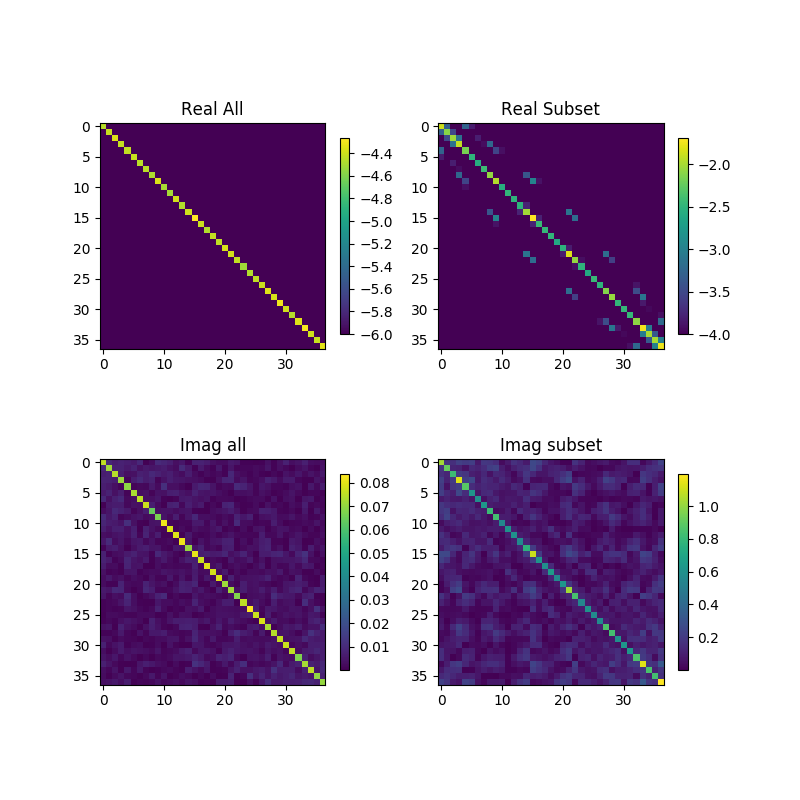

In [4]:
subgain = []
allgain = []

for ant in range(37):
    allgain.append(np.log(sol[(ant,'Jxx')][0]))
    subgain.append(np.log(subsol[(ant,'Jxx')][0]))

subcovr = np.cov(np.real(subgain))
subcovi = np.cov(np.imag(subgain))

allcovr = np.cov(np.real(allgain))
allcovi = np.cov(np.imag(allgain))

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('Real All')
plt.imshow(np.log(np.abs(allcovr)),vmin=-6)
plt.colorbar(shrink=0.7)

plt.subplot(222)
plt.title('Real Subset')
plt.imshow(np.log(np.abs(subcovr)),vmin=-4)
plt.colorbar(shrink=0.7)

plt.subplot(223)
plt.title('Imag all')
plt.imshow(np.abs(allcovi))
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.title('Imag subset')
plt.imshow(np.abs(subcovi))
plt.colorbar(shrink=0.7)

<IPython.core.display.Javascript object>


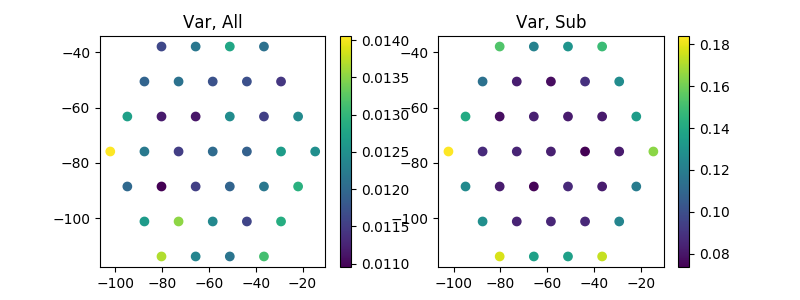

In [5]:
x = [v[0] for v in antpos.values()]
y = [v[1] for v in antpos.values()]

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.title('Var, All')
plt.scatter(x,y,c=np.diag(allcovr),cmap='viridis')
plt.colorbar()
plt.subplot(122)
plt.title('Var, Sub')
plt.scatter(x,y,c=np.diag(subcovr),cmap='viridis')
plt.colorbar()
plt.show()

# Scatter in All Visibilities

The sub-redcal system does not calibrate over all the redundant baseline sets, so naturally the scatter of the visibilities that have not been conditioned over will be larger. How much?

In [6]:
def calibrate(data,gains):
    calib_data = {}
    for (i, j, pol) in data.keys():
        calib_data[(i, j, pol)] = data[(i, j, pol)]/(gains[(i,'Jxx')] * np.conj(gains[(j,'Jxx')]))
    return calib_data

In [7]:
Nsim = 1024

# Simulate gains and visibilities
true_gains, true_vis, true_data = redcal.sim_red_data(reds, shape=(1,1), gain_scatter=0.1)
data = {k:v+0.05*redcal.noise((1,Nsim)) for k,v in true_data.items()}

gains_input = {}
for k in true_gains.keys():
    gains_input[k] = np.repeat(true_gains[k], Nsim,axis=1)
    
redcalibrator = redcal.RedundantCalibrator(reds)
sol_degen = redcalibrator.logcal(data)
sol_degen = redcalibrator.lincal(data, sol_degen)
sol = redcalibrator.remove_degen(antpos, sol_degen[1], degen_sol=gains_input)

redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
subsol_degen = redcalibrator_sub.logcal(data)
subsol_degen = redcalibrator_sub.lincal(data, subsol_degen)
subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen[1], degen_sol=gains_input)

# Correct all visibilities with the computed gains
all_bl_visib = calibrate(data, sol)
sub_bl_visib = calibrate(data, subsol)

<IPython.core.display.Javascript object>


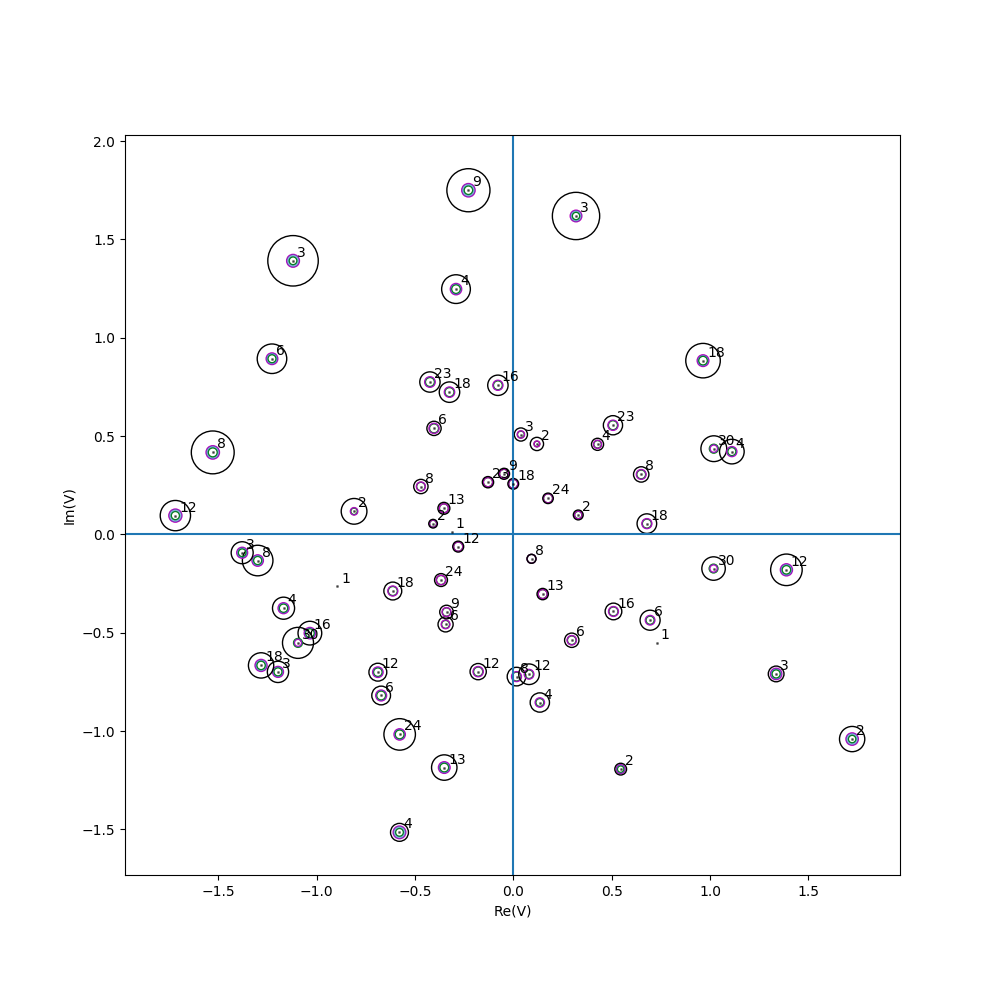

In [18]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.set_aspect('equal')
ax.axvline()
ax.axhline()
ax.set_xlabel('Re(V)')
ax.set_ylabel('Im(V)')
for i,k in enumerate(true_vis.keys()):
    subreds = [bls for bls in reds if k in bls][0]

    redsol_allbl = []; redsol_subbl = []; reddata = []

    for subbl in subreds:
        # Get variance of solutions
        redsol_allbl.append(np.abs(all_bl_visib[subbl]-true_vis[k]))
        redsol_subbl.append(np.abs(sub_bl_visib[subbl]-true_vis[k]))
        reddata.append(np.abs(data[subbl]-true_vis[k]))

        # Plot initial data, full solution and sub solution
#         ax.plot(np.mean(np.real(data[subbl])), np.mean(np.imag(data[subbl])), 'co', alpha=0.2)
#         ax.plot(np.mean(np.real(all_bl_visib[subbl])),np.mean(np.imag(all_bl_visib[subbl])), 
#                 'g^', alpha=0.5, markersize=5)
#         ax.plot(np.mean(np.real(sub_bl_visib[subbl])),np.mean(np.imag(sub_bl_visib[subbl])),
#                 'mo', alpha=0.5, markersize=5)

    # Draw a circle around max variance
    vis_r, vis_i = np.real(true_vis[k]), np.imag(true_vis[k])
    mean_std_all = np.sqrt(np.mean(np.std(redsol_allbl,axis=0)**2))
    mean_std_sub = np.sqrt(np.mean(np.std(redsol_subbl,axis=0)**2))
    mean_std_data = np.sqrt(np.mean(np.std(reddata, axis=0)**2))
    
    circ1 = plt.Circle((vis_r, vis_i),radius= mean_std_all,  color='g',fill=False); ax.add_patch(circ1)
    circ2 = plt.Circle((vis_r, vis_i),radius= mean_std_sub,  color='m',fill=False); ax.add_patch(circ2)
    circ3 = plt.Circle((vis_r, vis_i),radius= mean_std_data, color='k',fill=False); ax.add_patch(circ3)

    w = Wedge((vis_r[0][0],vis_i[0][0]), mean_std_sub, 
              theta1= 0, theta2= 360, width=(mean_std_sub- mean_std_all), alpha=0.5)
    ax.add_patch(w)

    # Plot true solution
    ax.plot(vis_r, vis_i, 'ks', alpha=0.5, markersize=1)

    # Annotate with number of redundant measurements
    ax.annotate('%d'%len(subreds),(vis_r+0.02, vis_i+0.02))

# Chi-squared per degrees of freedom

In [70]:
chisq_sub = 0; chisq_all = 0; chisq_data = 0

for k in true_vis.keys():
    subreds = [bls for bls in reds if k in bls][0]
    for subbl in subreds:
        chisq_sub += np.abs(sub_bl_visib[subbl]-true_vis[k])**2/((90-40+4)*(0.05)**2)
        chisq_all += np.abs(all_bl_visib[subbl]-true_vis[k])**2/((666-100+4)*(0.05)**2)
print chisq_sub
print chisq_all

[[16.09389081 14.13197213 15.13718381 ... 14.0229452  16.23146643
  15.25628109]]
[[1.11352371 0.99997398 1.00734664 ... 1.05009158 1.04492849 1.07267044]]


In [78]:
chisq_sub = 0; chisq_all = 0
model_vis_sub ={}

for k in true_vis.keys():
    subreds = [bls for bls in reds if k in bls][0]
    if k in subsol.keys():
        model_vis_sub[k] = subsol[k]
        continue
    model_vis_sub[k] = 0
    for subbl in subreds:
        model_vis_sub[k] += sub_bl_visib[subbl]/len(subreds)

for k in true_vis.keys():
    subreds = [bls for bls in reds if k in bls][0] 
    for subbl in subreds:
        chisq_all += np.abs((sol[subbl[0],'Jxx']*np.conj(sol[subbl[1],'Jxx'])*sol[k] -data[subbl]))**2
        chisq_sub += np.abs((subsol[subbl[0],'Jxx']*np.conj(subsol[subbl[1],'Jxx'])*vis_m_sub[k] -data[subbl]))**2
chisq_all = chisq_all/((666-100+4)*0.05**2)
chisq_sub = chisq_sub/((666-100+4)*0.05**2)
#     subreds = [bls for bls in reds if k in bls][0]
#     vis = 0
#     for subbl in subreds:
#         vis += 
        
#     chisq_sub += np.abs(data[subbl]-true_vis[k])**2/((90-40+4)*(0.05)**2)
#     chisq_all += np.abs(all_bl_visib[subbl]-true_vis[k])**2/((666-100+4)*(0.05)**2)
print chisq_sub
print chisq_all

[[1.50444046 1.31693858 1.375146   ... 1.28864929 1.52809235 1.40360475]]
[[1.06596997 0.95475242 0.96242447 ... 1.00466598 0.9988357  1.00802943]]


<IPython.core.display.Javascript object>


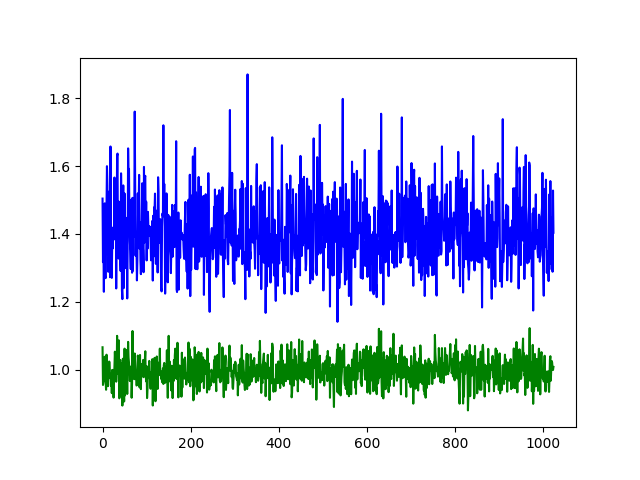

In [72]:
plt.figure()
plt.plot(chisq_all[0],'g')
plt.plot(chisq_sub[0],'b')

## Average over gains

In [73]:
Navg = 8

gain_all = {}
gain_sub = {}

for k in true_gains.keys():
    gain_all[k] = np.repeat(np.mean(sol[(0,'Jxx')].reshape(-1,8), axis=1), 8, axis=0)
    gain_sub[k] = np.repeat(np.mean(subsol[(0,'Jxx')].reshape(-1,8), axis=1), 8, axis=0)

<IPython.core.display.Javascript object>


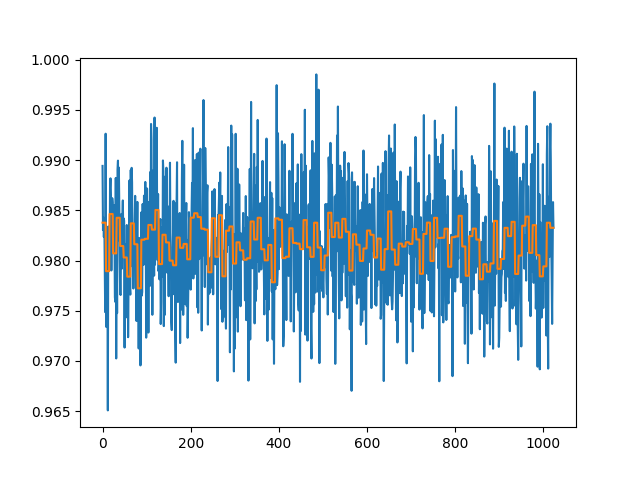

In [74]:
plt.figure()
plt.plot(sol[(0,'Jxx')][0])
plt.plot(gain_all[(0,'Jxx')])

In [79]:
chisq_sub = 0

for k in true_vis.keys():
    subreds = [bls for bls in reds if k in bls][0] 
    for subbl in subreds:
        chisq_sub += np.abs((gain_sub[subbl[0],'Jxx']*np.conj(gain_sub[subbl[1],'Jxx'])*vis_m_sub[k] -data[subbl]))**2
chisq_sub = chisq_sub/((666-100+4)*0.05**2)

print chisq_sub

[[13.51966918 13.15210431 13.09470307 ... 15.09872378 14.75012928
  14.99216598]]


<IPython.core.display.Javascript object>


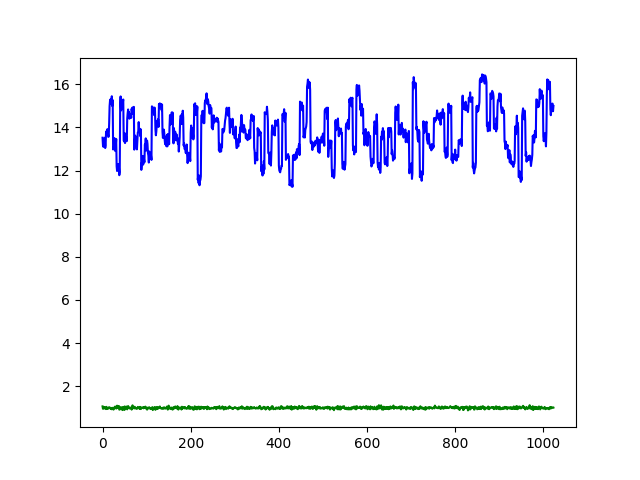

In [80]:
plt.figure()
plt.plot(chisq_all[0],'g')
plt.plot(chisq_sub[0],'b')

In [62]:
np.shape(chisq_all)

(1, 1024)

# Real time gain solutions from IDR 2.0

# Add lognormal noise to data

In [ ]:
Nsim = 2**10
gains = {}
gain_subsols_log = {}
gain_allsols_log = {}
noise = {}

for a in range(37):
    gains[(a,'x')] = []
    gain_subsols_log[(a,'x')] = []
    gain_allsols_log[(a,'x')] = []
    
gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,1))
for bl in data.keys():
    noise[bl] = []
    
for i in range(Nsim):
    print i
    gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,1))
    for k,v in data.items():
        n = redcal.noise((1,1))
        data[k] = np.exp(np.log(v) + n)
        noise[k].append(data[k]-v)
    
    redcalibrator = redcal.RedundantCalibrator(reds)
    sol_degen = redcalibrator.logcal(data)
    sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains_input)
    
    redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
    subsol_degen = redcalibrator_sub.logcal(data)
    subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains_input)
    
    for a in range(37):
        gains[(a,'x')].append(gains_input[(a,'x')][0][0])
        gain_subsols[(a,'x')].append(subsol[(a,'x')][0][0])
        gain_allsols[(a,'x')].append(sol[(a,'x')][0][0])
        
# Convert to numpy array from list for easy indexing
for a in range(37):
    gains[(a,'x')] = np.asarray(gains[(a,'x')])
    gain_subsols[(a,'x')] = np.asarray(gain_subsols[(a,'x')])
    gain_allsols[(a,'x')] = np.asarray(gain_allsols[(a,'x')])

In [ ]:
noise_allbls = []
for bl in noise.keys():
    noise_allbls.append(np.array(noise[bl])[:,0,0])
    
ncov = np.cov(noise_allbls)

plt.figure()
plt.imshow(np.real(ncov), interpolation='nearest')
plt.colorbar(shrink=0.75)

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(121)
hist, bins, misc = plt.hist(np.diag(np.real(noise_allbls)),bins=100)
plt.subplot(122)
hist, bins, misc = plt.hist(np.diag(np.imag(noise_allbls)),bins=100)

In [ ]:
Nsim = 2**10
gains = {}
gain_subsols = {}
gain_allsols = {}

for a in range(37):
    gains[(a,'x')] = []
    gain_subsols[(a,'x')] = []
    gain_allsols[(a,'x')] = []
    
for i in range(Nsim):
    print i
    gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,1))
    for k,v in data.items():
        n = redcal.noise((1,1))
        data[k] = v+ 2*n
    
    redcalibrator = redcal.RedundantCalibrator(reds)
    sol_degen = redcalibrator.logcal(data)
    sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains_input)
    
    redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
    subsol_degen = redcalibrator_sub.logcal(data)
    subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains_input)
    
    for a in range(37):
        gains[(a,'x')].append(gains_input[(a,'x')][0][0])
        gain_subsols[(a,'x')].append(subsol[(a,'x')][0][0])
        gain_allsols[(a,'x')].append(sol[(a,'x')][0][0])

# Convert to numpy array from list for easy indexing
for a in range(37):
    gains[(a,'x')] = np.asarray(gains[(a,'x')])
    gain_subsols[(a,'x')] = np.asarray(gain_subsols[(a,'x')])
    gain_allsols[(a,'x')] = np.asarray(gain_allsols[(a,'x')])

In [ ]:
noise_allbls = []
for bl in noise.keys():
    noise_allbls.append(np.array(noise[bl])[:,0,0])
    
ncov = np.cov(noise_allbls)

plt.figure()
plt.imshow(np.real(ncov), interpolation='nearest')
plt.colorbar(shrink=0.75)

In [ ]:
ant_gainres = []
ant_gainres_all = []
N = 1024

for ant in gains.keys():
    ant_gainres_all.append(gain_allsols[ant][:N]-np.mean(gain_allsols[ant][:N]))
    ant_gainres.append(gain_subsols[ant][:N]-np.mean(gain_subsols[ant][:N]))
    #ant_gainres_all.append(gain_allsols[ant][:N]-gains[ant][:N])
    #ant_gainres.append(gain_subsols[ant][:N]-gains[ant][:N])

# np.shape(ant_gainres)
cov = np.cov(ant_gainres)
cov_all = np.cov(ant_gainres_all)

#cov = np.dot(ant_gainres, np.conjugate(ant_gainres).T)/(np.shape(ant_gainres)[1]-1)
#cov_all = np.dot(ant_gainres_all,np.conjugate(ant_gainres_all).T)/(np.shape(ant_gainres_all)[1]-1)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.real(cov))
plt.colorbar(shrink=0.7)

plt.subplot(222)
plt.imshow(np.real(cov_all))
plt.colorbar(shrink=0.7)

plt.subplot(223)
plt.imshow(np.imag(cov))
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.imshow(np.imag(cov_all))
plt.colorbar(shrink=0.7)

# plt.matshow(np.log10(np.abs(cov)))
# plt.colorbar(shrink=0.7)

# plt.matshow(np.log10(np.abs(cov_all)))
# plt.colorbar(shrink=0.7)

In [ ]:
for a in range(37):
    gains[(a,'x')] = np.asarray(gains[(a,'x')])
    gain_subsols[(a,'x')] = np.asarray(gain_subsols[(a,'x')])
    gain_allsols[(a,'x')] = np.asarray(gain_allsols[(a,'x')])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for ant in range(0,37):
    fig.suptitle('Ant %d'%ant)
    ax.clear()
    ax.semilogy(np.abs(gains[(ant,'x')]),'c',label='All baselines',alpha=0.3)
    ax.semilogy(np.abs(gain_allsols[(ant,'x')]-gains[(ant,'x')]),'b',label='All baselines',alpha=0.7)
    ax.semilogy(np.abs(gain_subsols[(ant,'x')]-gains[(ant,'x')]),'m',label='Only shortest baselines',alpha=0.3)
    #ax.semilogy(np.abs(gains[(ant,'x')][0]),'g',label='Input gains',alpha=0.7)
#     ax.plot(np.angle(subsol[(ant,'x')][0])-np.angle(gains[(ant,'x')][0]),'m',label='Only shortest baselines',alpha=0.5)
#     ax.plot(np.angle(sol[(ant,'x')][0])-np.angle(gains[(ant,'x')][0]),'b',label='All baselines',alpha=0.7)
#     #ax.plot(np.angle(gains[(ant,'x')][0]),'g',label='Input gains',alpha=0.7)
    time.sleep(1)
    fig.canvas.draw()

## Single simulation

In [ ]:
gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,1))
data = {k:v+0*redcal.noise((1,1)) for k,v in data.items()}

redcalibrator = redcal.RedundantCalibrator(reds)
sol_degen = redcalibrator.logcal(data)
sol = redcalibrator.remove_degen(antpos, sol_degen, degen_sol=gains_input)
    
redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
subsol_degen = redcalibrator_sub.logcal(data)
subsol = redcalibrator_sub.remove_degen(antpos, subsol_degen, degen_sol=gains_input)

In [ ]:
ant_gainres = []
ant_gainres_all = []

for ant in range(37):
    ant_gainres_all.append((sol[(ant,'x')][0]))
    ant_gainres.append((subsol[(ant,'x')][0]))

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(np.dot(np.abs(ant_gainres),np.transpose(np.abs(ant_gainres))))
plt.subplot(122)
plt.imshow(np.dot(np.abs(ant_gainres_all),np.transpose(np.abs(ant_gainres_all))))